# DC Simulation

This notebook aims at simulating the DC case, with the following assumptions:
- 5-node network
- full observability: the current and the voltage at each node is measured
- Gaussian noise: the measurement noise on current and voltage is Gaussian
- independent noise: the noise on each node is independent and the noise on current and voltage on the same node is independent
- the noise has zero mean and standard deviation `noise_sigma` on each node and variable
- a number `n_samples` of samples is collected
- the voltage on each node is independent, has a Gaussian distribution with mean 1 and standard deviation `v_sigma`

We are not going to use here the solver from the main codebase to keep the experimentation harmless

## Setup

We create the admittance matrix and we simulate the voltage and current

In [5]:
import numpy as np
import cvxpy as cp
from numpy.random import default_rng
from matplotlib import pyplot as plt

import sys
sys.path.append('..')
from src.identification.error_metrics import error_metrics


In [6]:
v_sigma = 0.1
noise_sigma = 0.001
n_samples = 100

actual_admittance = np.array([
    [2, -1, -1, 0, 0],
    [-1, 1, 0, 0, 0],
    [-1, 0, 1, 0, 0],
    [0, 0, 0, 2, -2],
    [0, 0, 0, -2, 2]
])

n_nodes = actual_admittance.shape[0]

rng = default_rng(11)
actual_voltages = rng.normal(1, v_sigma, (n_samples, n_nodes))
actual_currents = actual_voltages @ actual_admittance
noise_voltages = rng.normal(0, noise_sigma, (n_samples, n_nodes))
noise_currents = rng.normal(0, noise_sigma, (n_samples, n_nodes))
measured_voltages = actual_voltages + noise_voltages
measured_currents = actual_currents + noise_currents

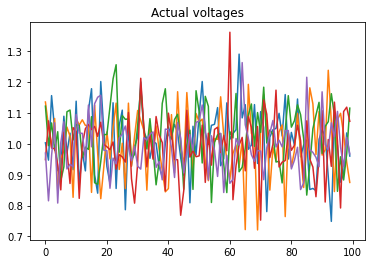

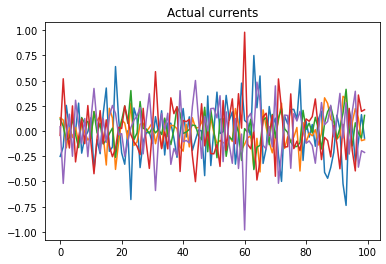

In [7]:
plt.plot(actual_voltages)
plt.title('Actual voltages')
plt.show()

plt.plot(actual_currents)
plt.title('Actual currents')
plt.show()

Of course, actual currents and voltages are not realistic and real networks would result in much more correlated voltages and smaller currents.
Still, we'll start from the simplest condition.

## Lasso estimation
We try first with a standard LASSO algorithm.
The optimization problem is solved with `cvxopt` and `gurobi`.
The hypterparameter $\lambda$ is chosen against the real admittance matrix.
Again, this is not realistic, but it is the simplest way.

In [10]:
def lasso(x: np.array, y: np.array, actual_beta: np.array) -> dict:
    n = x.shape[1]
    l = cp.Parameter(nonneg=True)
    beta = cp.Variable((n, n))

    def lasso_loss(x, y, beta, l):
        return cp.norm2(cp.vec(y - x @ beta)) ** 2 + l * cp.norm1(cp.vec(beta))

    problem = cp.Problem(cp.Minimize(lasso_loss(x, y, beta, l)))

    l_values = np.logspace(-6, 1, 50)
    cv_trials = []

    for l_value in l_values:
        l.value = l_value
        problem.solve()
        cv_trials.append({'l': l.value, 'beta': beta.value})

    _, value = min(enumerate(cv_trials), key=lambda t: np.linalg.norm(actual_beta - t[1]['beta'], 'fro'))
    return value

lasso_res = lasso(measured_voltages, measured_currents, actual_admittance)
lasso_lambda = lasso_res['l']
lass_admittance = lasso_res['beta']
lasso_error = error_metrics(actual_admittance, lass_admittance)
print(f'Best lambda: {lasso_lambda}')
lasso_error

Best lambda: 0.0019306977288832496


ErrorMetrics(fro_error=0.007752229882400171, max_error=0.0033696268476943736, rrms_error=0.0015203373632390607, map_error=0.0011405729053851823)

## TLS estimation
As all the matrices are real-valued, we do not need any transformation to apply TLS

In [9]:
def tls(x: np.array, y:np.array) -> np.array:
    n = x.shape[1]
    u, s, vh = np.linalg.svd(np.block([x, y]))
    v = vh.conj().T
    v_xy = v[:n, n:]
    v_yy = v[n:, n:]
    beta = - v_xy @ np.linalg.inv(v_yy)
    return beta

tls_admittance = tls(measured_voltages, measured_currents)
tls_error = error_metrics(actual_admittance, tls_admittance)
tls_error

ErrorMetrics(fro_error=0.009138893768776728, max_error=0.0033341236010434668, rrms_error=0.001792284525370925, map_error=0.0010947121601045837)

## S-TLS estimation


## Evaluation